## 영상 2개 concat해서 띄우기

In [6]:
import numpy as np
import os
import cv2
import mediapipe as mp
import timeit
import pandas as pd


import jk_module

'''root_dir_1 = 'C:/Users/jk/Bagel/data/RepCount_pose/video/test'
video_files_1 = sorted(os.listdir(root_dir_1))

root_dir_2 = 'C:/Users/jk/Bagel/data/RepCount_pose/video/test'
video_files_2 = sorted(os.listdir(root_dir_2))'''

out_dir = 'D:/Bagel/action_assess/output/0.mp4'


'''input_video_dir_1 = os.path.join(root_dir_1,'stu8_71.mp4')
input_video_dir_2 = os.path.join(root_dir_2,'stu8_71.mp4')
'''
cap1 = cv2.VideoCapture('D:/bagel/action_project2/data/stu8_71.mp4')
cap2 = cv2.VideoCapture('D:/bagel/action_project2/data/stu3_28.mp4')
#cap2 = cv2.VideoCapture(1)
   
width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH)) #1920
height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)) #1080
fps1 = int(cap1.get(cv2.CAP_PROP_FPS))
num_frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))

width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps2 = int(cap2.get(cv2.CAP_PROP_FPS))
num_frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
'''
if width1 != width2 or height1 != height2 or fps1 != fps2:
        raise ValueError("Dimensions or FPS of the videos are not the same.")'''
# Define the output video file
output_width = width1 + width2 + width2 
output_height = max(height1, height2)
output_fps = fps1  # Use the FPS of the first video
print(out_dir)
output_video = cv2.VideoWriter(out_dir, cv2.VideoWriter_fourcc(*'mp4v'), output_fps, (2880, 540))


mp_drawing = mp.solutions.drawing_utils 
mp_pose = mp.solutions.pose

with mp_pose.Pose(min_detection_confidence=0.9, min_tracking_confidence=0.9) as pose:
    trainer_angle_history = []
    user_angle_history = []

    tbetween_down_excellent = []
    tbetween_up_excellent = []
    tbetween_down_good = []
    tbetween_up_good = []
    tbetween_down_miss = []
    tbetween_up_miss = []

    tbetween_mean = []
    tbetween_std = []

    ubetween_mean = []
    ubetween_std = []

    score = []

    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        try:
            frame1 = cv2.resize(frame1, dsize = (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            frame2 = cv2.resize(frame2, dsize = (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            
            width1 = frame1.shape[1]
            height1 = frame1.shape[0]
            width2 = frame2.shape[1]
            height2 = frame2.shape[0]
            
            if not ret1 or not ret2:
                break

            # 시작 시점 측정
            start_t = timeit.default_timer()
        
        # mediapipe 결과 추출
            image1, results1 = jk_module.mediapipe_detection(frame1, pose)
            image2, results2 = jk_module.mediapipe_detection(frame2, pose)
            image3 = np.zeros((frame1.shape[0] , frame1.shape[1] , 3), dtype=np.uint8) + 222
        
            # mediapipe 시각화
            mp_drawing.draw_landmarks(image1, results1.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                            )    
            mp_drawing.draw_landmarks(image2, results2.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                            )    
            
            # 관찰 keypoints 지정
            main_idx = [12,14,16]

            # 주요 관절 각도   
            tvec1, tvec2 = jk_module.vec_of_angle(results1, main_idx)
            tangle = jk_module.angle_between_vectors(tvec1,tvec2)
            vec1, vec2 = jk_module.vec_of_angle(results2, [12,14,16])
            angle = jk_module.angle_between_vectors(vec1,vec2)
            print('tangel',tangle)
            print('angel',angle)
            # 관절 각도 list저장
            trainer_angle_history.append(tangle)
            user_angle_history.append(angle)

            # 주요 관절 시각화
            image1 = jk_module.red_circle_idx(image1, results1, main_idx, width1, height1)
            image2 = jk_module.red_circle_idx(image2, results2, [12,14,16], width2, height2)

            # plot그리기
            df = pd.DataFrame(trainer_angle_history, columns=['trainer_angles'])
            df['user_angles'] = user_angle_history

            ##trainer
            window = 20
            tmean = df['trainer_angles'][-window:].mean()
            tstd = df['trainer_angles'][-window:].std()
            
            tbetween_mean.append(tmean)
            tbetween_std.append(tstd)
            down_excellent_value = tmean - 1*tstd
            up_excellent_value = tmean + 1*tstd
            down_good_value = tmean - 2*tstd
            up_good_value = tmean + 2*tstd
            down_miss_value = tmean - 3*tstd
            up_miss_value = tmean + 3*tstd

            tbetween_down_excellent.append(down_excellent_value)
            tbetween_up_excellent.append(up_excellent_value)
            tbetween_down_good.append(down_good_value)
            tbetween_up_good.append(up_good_value)
            tbetween_down_miss.append(down_miss_value)
            tbetween_up_miss.append(up_miss_value)
    
            df['t_between_mean'] = tbetween_mean
            df['t_between_std'] = tbetween_std
            df['t_between_down_excellent'] = tbetween_down_excellent
            df['t_between_up_excellent'] = tbetween_up_excellent
            df['t_between_down_good'] = tbetween_down_good
            df['t_between_up_good'] = tbetween_up_good
            df['t_between_down_miss'] = tbetween_down_miss
            df['t_between_up_miss'] = tbetween_up_miss

            ##user
            umean = df['user_angles'][-window:].mean()
            ustd = df['user_angles'][-window:].std()
            
            ubetween_mean.append(umean)
            ubetween_std.append(ustd)
        
            df['u_between_mean'] = ubetween_mean
            df['u_between_std'] = ubetween_std

            ## score
            if umean < up_excellent_value and umean > down_excellent_value:
                score.append('excellent')
            elif umean  < up_good_value and umean > down_good_value:
                score.append('good')
            elif umean  < up_miss_value and umean > down_miss_value:
                score.append('miss')
            else:
                score.append('null')

            df['score'] = score

            image3 = jk_module.scatter_plot(image=image3,
                                            history1=df['t_between_mean'],history2=df['u_between_mean'],
                                            between_y1=df['t_between_down_excellent'],between_y2=df['t_between_up_excellent'],
                                            between_y3=df['t_between_down_good'],between_y4=df['t_between_up_good'],
                                            between_y5=df['t_between_down_miss'],between_y6=df['t_between_up_miss'],
                                            xlim=300)

            concatenated_frame = np.zeros(( height1 ,width1*3, 3), dtype=np.uint8)
            concatenated_frame[:, :width1] = image1
            concatenated_frame[:, width1:width1+width2] = image2
            concatenated_frame[:, width1+width2:] = image3
            print(( height1 ,width1*3, 3))
            end_t = timeit.default_timer()
            FPS = 1./(end_t - start_t )

            if score[-1] == 'excellent':
                text_color = (0, 0, 255)  # Red
            elif score[-1] == 'good':
                text_color = (0, 165, 255)  # Orange
            elif score[-1] == 'miss':
                text_color = (0, 255, 0)  # Green
            elif score[-1] == 'null':
                text_color = (0, 0, 0)  # Black
            else:
                text_color = (255, 255, 255)  # White (Default color if score doesn't match any condition)
            
        
            cv2.putText(concatenated_frame, f'trainer : {tangle:.2f}', (10,50), cv2.FONT_ITALIC, 1, (255,0,0), 2)
            cv2.putText(concatenated_frame, f'user : {angle:.2f}', (970,50), cv2.FONT_ITALIC, 1, (255,0,0), 2)
            cv2.putText(concatenated_frame, f'FPS: {FPS:.2f}', (1930,350), cv2.FONT_ITALIC, 1, (255,0,0), 2)
            cv2.putText(concatenated_frame, f'score : {score[-1]}', (1930,380), cv2.FONT_ITALIC, 1,  text_color, 2)
            
            print('output_fps',output_fps)
            
        except:
            pass  
        cv2.imshow(f'name', concatenated_frame)
        output_video.write(concatenated_frame)   
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap1.release()
    cap2.release()
    output_video.release() 
    cv2.destroyAllWindows()


D:/Bagel/action_assess/output/0.mp4
tangel 99.61756857667987
angel 166.13801531144418
tangel 112.02007721242886
angel 172.41454335092402
tangel 96.89362603760077
angel 149.2014238217018
tangel 144.0333718221125
angel 177.00201049830216
tangel 112.95521718347291
angel 146.24103425797296
tangel 90.27697973377352
angel 137.08150191883954
tangel 77.32775901189785
angel 148.54110760065151
tangel 149.51184812806613
angel 171.26329981273147
tangel 123.23524470669324
angel 166.08959089566503
tangel 91.64718586413767
angel 152.52844769577393
tangel 98.18399744982221
angel 153.18550056176915
tangel 145.25477251976125
angel 163.88622483270927


In [5]:
width1*2

1920

In [7]:
df

,trainer_angles,user_angles,t_between_mean,t_between_std,t_between_down_excellent,t_between_up_excellent,t_between_down_good,t_between_up_good,t_between_down_miss,t_between_up_miss,u_between_mean,u_between_std,score
0,99.617569,166.138015,99.617569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,166.138015,NaN,null
1,112.020077,172.414543,105.818823,8.769898,97.048925,114.588721,88.279027,123.358619,79.509129,132.128517,169.276279,4.438176,null
2,96.893626,149.201424,102.843757,8.062791,94.780966,110.906548,86.718175,118.969340,78.655384,127.032131,162.584661,12.007580,null
3,144.033372,177.002010,113.141161,21.621405,91.519756,134.762566,69.898351,156.383971,48.276946,178.005376,166.188998,12.169072,miss
4,112.955217,146.241034,113.103972,18.724871,94.379102,131.828843,75.654231,150.553713,56.929360,169.278584,162.199405,13.807570,miss
5,90.276980,137.081502,109.299473,19.166165,90.133308,128.465639,70.967143,147.631804,51.800978,166.797969,158.013088,16.052125,miss
6,77.327759,148.541108,104.732086,21.263712,83.468373,125.995798,62.204661,147.259510,40.940949,168.523222,156.659948,15.084512,miss
7,149.511848,171.263300,110.329556,25.262752,85.066804,135.592308,59.804052,160.855060,34.541300,186.117812,158.485367,14.889381,good
8,123.235245,166.089591,111.763521,24.019515,87.744006,135.783037,63.724491,159.802552,39.704975,183.822068,159.330281,14.156513,good
9,91.647186,152.528448,109.751888,23.522323,86.229565,133.274211,62.707241,156.796534,39.184918,180.318858,158.650098,13.519095,miss


In [26]:
row = 0
i=0
h = []
for row in range(300):
    if df['u_between_mean'][row] < df['t_between_y2'][row] and df['t_between_y1'][row] < df['u_between_mean'][row]:
        h.append('a')
    else:
        h.append('b')
df['h'] = h
df[230:240]

,trainer_angles,user_angles,t_between_mean,t_between_std,t_between_y1,t_between_y2,t_between_y3,t_between_y4,u_between_mean,u_between_std,h
230,123.462970,152.725640,152.433435,12.714546,139.718889,165.147981,127.004344,177.862526,160.777086,4.878841,a
231,118.834560,148.858988,150.913204,13.900494,137.012710,164.813698,123.112216,178.714192,159.696284,5.601814,a
232,108.842062,145.081903,149.065619,15.638887,133.426732,164.704507,117.787845,180.343394,158.379346,6.549118,a
233,106.059365,143.787925,147.137418,17.231135,129.906283,164.368553,112.675148,181.599687,156.979876,7.285196,a
234,98.792678,140.260122,144.980032,19.064167,125.915864,164.044199,106.851697,183.108366,155.428558,8.209688,a
235,89.516752,136.358896,142.560637,21.292186,121.268451,163.852823,99.976266,185.145009,153.623077,9.235569,a
236,86.368863,134.183810,140.084169,23.336515,116.747654,163.420684,93.411139,186.757200,151.607597,9.980716,a
237,79.130867,131.839943,137.382433,25.519132,111.863301,162.901565,86.344168,188.420697,149.352962,10.391136,a
238,76.364589,132.507067,134.586439,27.449978,107.136461,162.036416,79.686484,189.486394,147.155681,10.223867,a
239,73.556795,133.747660,131.692894,29.160991,102.531903,160.853884,73.370913,190.014875,145.227995,9.808686,a


In [37]:
print(df['trainer_angles'][2:22].mean())
print(df['trainer_angles'][2:22].std())
print(df['between_y2'][21])
print(df['between_y1'][21])
print(df['between_y1'][21]+df['trainer_angles'][2:22].std())
df

73.08731876270906
9.574252931307226
73.08731876270906
63.51306583140183
73.08731876270906


,trainer_angles,user_angles,between_y1,between_y2
0,81.060291,156.492683,NaN,81.060291
1,84.629516,161.426037,80.321081,82.844904
2,85.237143,167.320068,81.385672,83.642317
3,80.619909,166.820430,80.503712,82.886715
4,70.573117,154.070068,74.543182,80.423995
5,61.426930,147.912410,67.886838,77.257818
6,62.683396,147.491347,65.001073,75.175757
7,62.964875,146.037951,63.287291,73.649397
8,63.443130,148.038200,62.242793,72.515367
9,63.763464,146.349254,61.567427,71.640177


In [19]:
df['trainer_angles'][:20]

0     81.060291
1     84.629516
2     85.237143
3     80.619909
4     70.573117
5     61.426930
6     62.683396
7     62.964875
8     63.443130
9     63.763464
10    63.633412
11    63.837441
12    68.468420
13    70.885103
14    72.216900
15    73.750553
16    74.457193
17    76.355708
18    83.194297
19    85.472524
Name: trainer_angles, dtype: float64

In [10]:
df['trainer_angles'][-10:]

15    73.750553
16    74.457193
17    76.355708
18    83.194297
19    85.472524
20    88.167257
21    90.595604
22    95.001980
23    96.017954
24    99.844158
Name: trainer_angles, dtype: float64

In [11]:
df

,trainer_angles,user_angles
0,81.060291,156.492683
1,84.629516,161.426037
2,85.237143,167.320068
3,80.619909,166.820430
4,70.573117,154.070068
5,61.426930,147.912410
6,62.683396,147.491347
7,62.964875,146.037951
8,63.443130,148.038200
9,63.763464,146.349254


In [10]:
df[:5]['trainer_angles'].mean()


80.42399524454282

In [13]:
df[:5]['trainer_angles'].std()*3

17.64243970275553

In [22]:
import numpy
x=numpy.arange(0.,1.05,0.05)
y1=numpy.sin(2*numpy.pi*x)
y2=y1+0.2
print(len(x))
print(len(y1))

21
21


In [26]:
df['trainer_angles']

0       81.060291
1       84.629516
2       85.237143
3       80.619909
4       70.573117
          ...    
188    120.137009
189    132.808667
190    137.093190
191    136.675971
192    137.442486
Name: trainer_angles, Length: 193, dtype: float64

In [31]:
df['trainer_angles'][-5:].mean()

132.8314646426113

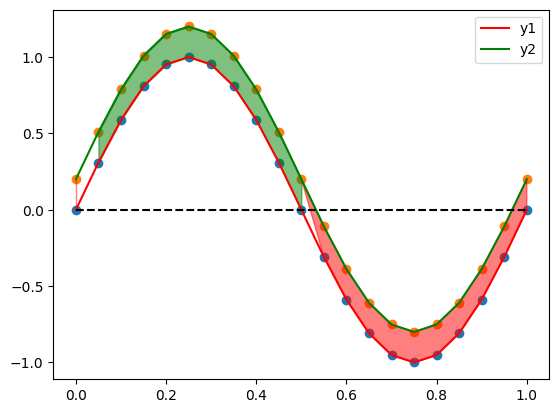

In [20]:
import matplotlib.pyplot as plt
import numpy

plt.figure()
x=numpy.arange(0.,1.05,0.05)
y1=numpy.sin(2*numpy.pi*x)
y2=y1+0.2
y1positive=y1>0
y1negative=y1<=0
plt.plot(x,y1,'r',label='y1')
plt.plot(x,y2,'g',label='y2')
plt.plot(x,x*0,'--k')
plt.scatter(x,y1)
plt.scatter(x,y2)
plt.fill_between(x,y2,y1,where=y1positive,color='green',alpha=0.5)
plt.fill_between(x,y2,y1,where=y1negative,color='red',alpha=0.5,interpolate=True)
plt.legend()

In [35]:
y = df['trainer_angles']
y.index

RangeIndex(start=0, stop=193, step=1)

In [ ]:
import matplotlib.pyplot as plt
import numpy

plt.figure()
y = df['trainer_angles']
x = y.index
plt.plot(x,y1,'r',label='y1')
plt.plot(x,y2,'g',label='y2')
plt.plot(x,x*0,'--k')
plt.scatter(x,y1)
plt.scatter(x,y2)
plt.fill_between(x,y2,y1,where=y1positive,color='green',alpha=0.5)
plt.fill_between(x,y2,y1,where=y1negative,color='red',alpha=0.5,interpolate=True)
plt.legend()

In [36]:
df['trainer_angles']

0       81.060291
1       84.629516
2       85.237143
3       80.619909
4       70.573117
          ...    
188    120.137009
189    132.808667
190    137.093190
191    136.675971
192    137.442486
Name: trainer_angles, Length: 193, dtype: float64

In [37]:
df['trainer_angles']+10

0       91.060291
1       94.629516
2       95.237143
3       90.619909
4       80.573117
          ...    
188    130.137009
189    142.808667
190    147.093190
191    146.675971
192    147.442486
Name: trainer_angles, Length: 193, dtype: float64